In [1]:
import random
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import PIL.Image as Image
import os
import math

In [2]:
from sklearn.model_selection import train_test_split
import torch
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms
from torch.utils.tensorboard import SummaryWriter


In [3]:
from resunet import ResUnet

In [4]:
class SegDataNp(Dataset):

    def __init__(self,image_paths,img_mean,img_std,transform = None):
        super().__init__()
        self.image_paths = image_paths
        self.transform = transform
        self.img_mean = img_mean
        self.img_std = img_std

    
    def __len__(self):
        return len(self.image_paths)

    def __getitem__(self, index):

        file =  np.load(self.image_paths[index])

        image = file[0]
        mask = file[1]

        image = torch.from_numpy(image).to(torch.float32)
        mask = torch.from_numpy(mask).to(torch.long)

        image = torch.unsqueeze(torch.unsqueeze(image,dim=0),dim=0)
        mask = torch.unsqueeze(torch.unsqueeze(mask,dim=0),dim=0)
        
        basic_image_transform = transforms.Compose(transforms=[
            transforms.Resize(size = (128,128)),
            transforms.Normalize(mean = self.img_mean,std = self.img_std),
        ])

        basic_mask_transform = transforms.Compose(transforms=[
            transforms.Resize(size = (128,128)),
        ])

        image = basic_image_transform(image)
        mask = basic_mask_transform(mask)

        if self.transform:

            image = self.transform(image)
            mask = self.transform(mask)
            
        image = image.squeeze()
        mask = mask.squeeze()
        
        sample = {'image':image,'mask':mask}

        return sample

In [5]:
data_dir = '/home/UFAD/s.kapoor/GrainGrowth/skapoor/dl_mis/ACDC/train_files'
total_input_files = []
for file in os.listdir(data_dir):
    if file.endswith('.npy'):
        total_input_files.append(os.path.join(data_dir,file))

In [6]:
from tqdm import tqdm

In [7]:
def train():

    seed = 13
    torch.manual_seed(seed)
    best_v_loss = 1_000_000

    use_cuda = torch.cuda.is_available()
    device = torch.device("cuda:3" if use_cuda else "cpu")
    
    model = ResUnet(in_channel = 1,out_channel = 4)
    model.to(device)
    epochs = 100
    loss_func = torch.nn.CrossEntropyLoss(weight = torch.tensor([0.0043484 , 0.3454297 , 0.32142933, 0.32879258])) # calculated class imbalance weight
    loss_func.to(device)
#     optimizer = torch.optim.Adam(model.parameters(),lr = 0.001)
    optimizer = torch.optim.SGD(model.parameters(),lr = 0.01,momentum = 0.9, weight_decay = 1e-4)
    scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer = optimizer,factor = 0.8,min_lr=1e-4)
    pth = os.getcwd()
    model_path = os.path.join(pth,'model_q3_resunet')
    log_dir = os.path.join(model_path,'runs')
    wts_path = os.path.join(model_path,'weigths')

    if os.path.exists(model_path) == False:
        os.mkdir(model_path)
        
        os.mkdir(log_dir)
        
        os.mkdir(wts_path)
    
    writer = SummaryWriter(log_dir=log_dir)

    #splitting the dataset into traininig and validation set
    train_img,valid_img = train_test_split(total_input_files,test_size=0.2,random_state=seed)
    train_data = SegDataNp(image_paths = train_img,img_mean=90,img_std=101) # calculated mean and std of the bianry images.
    valid_data = SegDataNp(image_paths = valid_img,img_mean=90,img_std=101)
    train_dataloader = DataLoader(train_data,batch_size = 8,shuffle = True,pin_memory = True)
    valid_dataloader = DataLoader(valid_data,batch_size = 8,shuffle = False,pin_memory = True)

    #print("After Model to device : ",torch.cuda.memory_allocated(device)/(1024*1024))
    for e in tqdm(range(epochs)):

        #training the model 
        print('Epoch {0}'.format(e+1))
        epoch_loss = 0.0
        run_loss = 0.0
        model.train(True)

        for i,batch in enumerate(train_dataloader):
            
            image = batch['image'].to(device)
            mask = batch['mask'].to(device)
            
            image = torch.unsqueeze(image,axis = 1)
            mask = torch.unsqueeze(mask,axis = 1)
            
            #print(image.size())
            #print(mask.size())
            
            
    
            #print(batch['image'].shape)
            v_img = transforms.RandomVerticalFlip(p=1)(image)
            h_img = transforms.RandomHorizontalFlip(p=1)(image)
            r_img = transforms.RandomRotation(degrees=(-25,25))(image)
            image_final = torch.cat((image,v_img,h_img,r_img),0)

            #print(image_final.shape)
                    
            v_mask = transforms.RandomVerticalFlip(p=1)(mask)
            h_mask = transforms.RandomHorizontalFlip(p=1)(mask)
            r_mask = transforms.RandomRotation(degrees=(-25,25))(mask)
            mask_final = torch.cat((mask,v_mask,h_mask,r_mask),0)
            mask_final = torch.squeeze(mask_final)
            #print(mask_final.shape)
            
            #break
            
#             image_final.to(device)
#             mask_final.to(device)
            
#             print(image_final.dtype)
#             print(mask_final.dtype)
#             print(device)
            #a = torch.cuda.memory_allocated(device)/(1024*1024)
            optimizer.zero_grad()
            pred = model.forward(image_final)
            #print("after forward pass", torch.cuda.memory_allocated(device)/(1024*1024))
            #b = torch.cuda.memory_allocated(device)/(1024*1024)
            #print("memory consumed by forward_pass",b-a)
            loss = loss_func(pred,mask_final)
            

            run_loss = run_loss + loss.item()
            epoch_loss = epoch_loss + loss.item()
            
            loss.backward()
            #print("memory after backward pass ", torch.cuda.memory_allocated(device)/(1024*1024))
            optimizer.step()
            #print("memory after optimizer ",torch.cuda.memory_allocated(device)/(1024*1024))

            #print('the current loss is {0}'.format(run_loss))
            
            #break
            
#             del mask_final
#             del image_final
#             del pred
#             del v_img
#             del h_img
#             del r_img
#             del v_mask
#             del h_mask
#             del r_mask
#             del mask
#             del image
            
            #print("memory after delete ",torch.cuda.memory_allocated(device)/(1024*1024))
            

            if(i%100 == 99):
                
#                 for obj in gc.get_objects():
#                     try:
#                         if torch.is_tensor(obj) or (hasattr(obj,'data') and torch.is_tensor(obg.data)):
#                             print(type(obj),obj.size())
#                     except:
#                         pass
                

                print("\tBatch Loss for curent for {0} is {1:.5f}".format(i,run_loss/100))
                run_loss = 0.0
                
        #break
        avg_e_loss = epoch_loss/(i+1)
        print('The average loss for the epoch is {0}'.format(avg_e_loss))

        #validating the model
        model.train(False)

        val_loss = 0.0

        for k,batch in enumerate(valid_dataloader):
            final_image = torch.unsqueeze(batch['image'],1).to(device)
            final_mask = batch['mask'].to(device)

            pred = model.forward(final_image)
            loss = loss_func(pred,final_mask)

            val_loss+= loss.item()
            
#             del final_image
#             del final_mask
            #break
        
        

        avg_val_loss = val_loss/(k+1)
        print('The average validation loss for the epoch is {0:.5f}'.format(avg_val_loss))
        writer.add_scalars('Training vs. Validation Loss',
                    { 'Training' : avg_e_loss, 'Validation' : avg_val_loss },
                    e)
        
        if avg_val_loss < best_v_loss:

            best_v_loss = avg_val_loss
            best_wt_path = os.path.join(wts_path,'best_epoch'+str(e))
            

        writer.flush()
        

        #break
        wt_path =  os.path.join(wts_path,'epoch_'+str(e))
        torch.save(model.state_dict(), wt_path)
    torch.save(model.state_dict(), best_wt_path)

In [8]:
train()

  0%|          | 0/100 [00:00<?, ?it/s]

Epoch 1
	Batch Loss for curent for 99 is 1.04351
The average loss for the epoch is 0.9524415606603572
The average validation loss for the epoch is 0.95802


  1%|          | 1/100 [01:25<2:21:13, 85.59s/it]

Epoch 2
	Batch Loss for curent for 99 is 0.64545
The average loss for the epoch is 0.5726355613838315
The average validation loss for the epoch is 0.35817


  2%|▏         | 2/100 [02:51<2:19:58, 85.70s/it]

Epoch 3
	Batch Loss for curent for 99 is 0.42284
The average loss for the epoch is 0.427388234210264
The average validation loss for the epoch is 0.37501


  3%|▎         | 3/100 [04:21<2:21:38, 87.62s/it]

Epoch 4
	Batch Loss for curent for 99 is 0.40811
The average loss for the epoch is 0.3744443763457044
The average validation loss for the epoch is 0.23586


  4%|▍         | 4/100 [05:47<2:19:19, 87.07s/it]

Epoch 5
	Batch Loss for curent for 99 is 0.30044
The average loss for the epoch is 0.30603218577919206
The average validation loss for the epoch is 0.20579


  5%|▌         | 5/100 [07:14<2:18:05, 87.21s/it]

Epoch 6
	Batch Loss for curent for 99 is 0.27721
The average loss for the epoch is 0.271021284982172
The average validation loss for the epoch is 0.18003


  6%|▌         | 6/100 [08:44<2:17:37, 87.84s/it]

Epoch 7
	Batch Loss for curent for 99 is 0.27073
The average loss for the epoch is 0.2667803343834053
The average validation loss for the epoch is 0.18567


  7%|▋         | 7/100 [10:10<2:15:32, 87.45s/it]

Epoch 8
	Batch Loss for curent for 99 is 0.25992
The average loss for the epoch is 0.24865498834567545
The average validation loss for the epoch is 0.17295


  8%|▊         | 8/100 [11:40<2:15:16, 88.22s/it]

Epoch 9
	Batch Loss for curent for 99 is 0.24814
The average loss for the epoch is 0.2422427985992731
The average validation loss for the epoch is 0.18789


  9%|▉         | 9/100 [13:06<2:12:48, 87.57s/it]

Epoch 10
	Batch Loss for curent for 99 is 0.23240
The average loss for the epoch is 0.23190494973934134
The average validation loss for the epoch is 0.18944


 10%|█         | 10/100 [14:33<2:10:51, 87.23s/it]

Epoch 11
	Batch Loss for curent for 99 is 0.24203
The average loss for the epoch is 0.23574402475856363
The average validation loss for the epoch is 0.16407


 11%|█         | 11/100 [16:01<2:09:48, 87.51s/it]

Epoch 12
	Batch Loss for curent for 99 is 0.21913
The average loss for the epoch is 0.22068158572256877
The average validation loss for the epoch is 0.16579


 12%|█▏        | 12/100 [17:27<2:07:44, 87.10s/it]

Epoch 13
	Batch Loss for curent for 99 is 0.21656
The average loss for the epoch is 0.2135420104596003
The average validation loss for the epoch is 0.21131


 13%|█▎        | 13/100 [18:53<2:05:58, 86.88s/it]

Epoch 14
	Batch Loss for curent for 99 is 0.20567
The average loss for the epoch is 0.20875238900253285
The average validation loss for the epoch is 0.15628


 14%|█▍        | 14/100 [20:21<2:05:04, 87.27s/it]

Epoch 15
	Batch Loss for curent for 99 is 0.19398
The average loss for the epoch is 0.19840798768853643
The average validation loss for the epoch is 0.14822


 15%|█▌        | 15/100 [21:48<2:03:13, 86.98s/it]

Epoch 16
	Batch Loss for curent for 99 is 0.19997
The average loss for the epoch is 0.20294364413041718
The average validation loss for the epoch is 0.17876


 16%|█▌        | 16/100 [23:17<2:02:40, 87.62s/it]

Epoch 17
	Batch Loss for curent for 99 is 0.22231
The average loss for the epoch is 0.21550809904074794
The average validation loss for the epoch is 0.16212


 17%|█▋        | 17/100 [24:43<2:00:41, 87.25s/it]

Epoch 18
	Batch Loss for curent for 99 is 0.20188
The average loss for the epoch is 0.197479587730937
The average validation loss for the epoch is 0.14768


 18%|█▊        | 18/100 [26:09<1:58:36, 86.79s/it]

Epoch 19
	Batch Loss for curent for 99 is 0.19901
The average loss for the epoch is 0.19435977526204123
The average validation loss for the epoch is 0.16373


 19%|█▉        | 19/100 [27:37<1:57:41, 87.18s/it]

Epoch 20
	Batch Loss for curent for 99 is 0.18520
The average loss for the epoch is 0.19130266235448928
The average validation loss for the epoch is 0.15186


 20%|██        | 20/100 [29:03<1:55:42, 86.79s/it]

Epoch 21
	Batch Loss for curent for 99 is 0.18806
The average loss for the epoch is 0.18546432884731842
The average validation loss for the epoch is 0.15042


 21%|██        | 21/100 [30:29<1:54:03, 86.62s/it]

Epoch 22
	Batch Loss for curent for 99 is 0.18286
The average loss for the epoch is 0.18352885033291672
The average validation loss for the epoch is 0.14198


 22%|██▏       | 22/100 [31:57<1:53:05, 86.99s/it]

Epoch 23
	Batch Loss for curent for 99 is 0.18285
The average loss for the epoch is 0.18263409427167232
The average validation loss for the epoch is 0.14552


 23%|██▎       | 23/100 [33:23<1:51:21, 86.78s/it]

Epoch 24
	Batch Loss for curent for 99 is 0.17244
The average loss for the epoch is 0.17567957102940346
The average validation loss for the epoch is 0.15001


 24%|██▍       | 24/100 [34:50<1:50:02, 86.88s/it]

Epoch 25
	Batch Loss for curent for 99 is 0.17694
The average loss for the epoch is 0.17847940852348718
The average validation loss for the epoch is 0.13770


 25%|██▌       | 25/100 [36:18<1:48:56, 87.15s/it]

Epoch 26
	Batch Loss for curent for 99 is 0.17311
The average loss for the epoch is 0.17538050608953257
The average validation loss for the epoch is 0.14743


 26%|██▌       | 26/100 [37:44<1:47:07, 86.86s/it]

Epoch 27
	Batch Loss for curent for 99 is 0.17860
The average loss for the epoch is 0.17609840771914775
The average validation loss for the epoch is 0.14915


 27%|██▋       | 27/100 [39:13<1:46:19, 87.39s/it]

Epoch 28
	Batch Loss for curent for 99 is 0.17815
The average loss for the epoch is 0.17022717794822773
The average validation loss for the epoch is 0.12864


 28%|██▊       | 28/100 [40:39<1:44:19, 86.94s/it]

Epoch 29
	Batch Loss for curent for 99 is 0.17177
The average loss for the epoch is 0.17009330135209397
The average validation loss for the epoch is 0.13863


 29%|██▉       | 29/100 [42:05<1:42:27, 86.58s/it]

Epoch 30
	Batch Loss for curent for 99 is 0.16345
The average loss for the epoch is 0.16578983983600326
The average validation loss for the epoch is 0.13767


 30%|███       | 30/100 [43:33<1:41:44, 87.21s/it]

Epoch 31
	Batch Loss for curent for 99 is 0.16457
The average loss for the epoch is 0.16685145469236123
The average validation loss for the epoch is 0.18237


 31%|███       | 31/100 [45:00<1:39:59, 86.94s/it]

Epoch 32
	Batch Loss for curent for 99 is 0.16401
The average loss for the epoch is 0.1657225694019757
The average validation loss for the epoch is 0.14979


 32%|███▏      | 32/100 [46:27<1:38:49, 87.20s/it]

Epoch 33
	Batch Loss for curent for 99 is 0.16754
The average loss for the epoch is 0.16646839366221303
The average validation loss for the epoch is 0.13850


 33%|███▎      | 33/100 [47:56<1:37:48, 87.59s/it]

Epoch 34
	Batch Loss for curent for 99 is 0.15747
The average loss for the epoch is 0.15760794406786016
The average validation loss for the epoch is 0.15226


 34%|███▍      | 34/100 [49:22<1:35:44, 87.04s/it]

Epoch 35
	Batch Loss for curent for 99 is 0.15790
The average loss for the epoch is 0.16022070821043086
The average validation loss for the epoch is 0.14105


 35%|███▌      | 35/100 [50:51<1:34:52, 87.58s/it]

Epoch 36
	Batch Loss for curent for 99 is 0.15749
The average loss for the epoch is 0.16013878958387526
The average validation loss for the epoch is 0.21984


 36%|███▌      | 36/100 [52:17<1:33:01, 87.21s/it]

Epoch 37
	Batch Loss for curent for 99 is 0.16864
The average loss for the epoch is 0.1655448012014958
The average validation loss for the epoch is 0.15512


 37%|███▋      | 37/100 [53:44<1:31:26, 87.08s/it]

Epoch 38
	Batch Loss for curent for 99 is 0.15313
The average loss for the epoch is 0.15396422775784088
The average validation loss for the epoch is 0.12980


 38%|███▊      | 38/100 [55:12<1:30:25, 87.50s/it]

Epoch 39
	Batch Loss for curent for 99 is 0.14980
The average loss for the epoch is 0.15194577910981252
The average validation loss for the epoch is 0.13532


 39%|███▉      | 39/100 [56:39<1:28:44, 87.29s/it]

Epoch 40
	Batch Loss for curent for 99 is 0.14846
The average loss for the epoch is 0.14916834410728586
The average validation loss for the epoch is 0.13717


 40%|████      | 40/100 [58:07<1:27:24, 87.41s/it]

Epoch 41
	Batch Loss for curent for 99 is 0.14888
The average loss for the epoch is 0.1486528522057059
The average validation loss for the epoch is 0.14352


 41%|████      | 41/100 [59:35<1:26:15, 87.72s/it]

Epoch 42
	Batch Loss for curent for 99 is 0.17929
The average loss for the epoch is 0.17107870917357698
The average validation loss for the epoch is 0.13505


 42%|████▏     | 42/100 [1:01:07<1:25:56, 88.90s/it]

Epoch 43
	Batch Loss for curent for 99 is 0.15287
The average loss for the epoch is 0.14985686146620056
The average validation loss for the epoch is 0.13358


 43%|████▎     | 43/100 [1:02:28<1:22:21, 86.69s/it]

Epoch 44
	Batch Loss for curent for 99 is 0.14458
The average loss for the epoch is 0.14196105348190088
The average validation loss for the epoch is 0.13494


 44%|████▍     | 44/100 [1:03:50<1:19:37, 85.32s/it]

Epoch 45
	Batch Loss for curent for 99 is 0.15045
The average loss for the epoch is 0.1492998798948308
The average validation loss for the epoch is 0.14381


 45%|████▌     | 45/100 [1:05:12<1:17:12, 84.22s/it]

Epoch 46
	Batch Loss for curent for 99 is 0.14057
The average loss for the epoch is 0.14447246593330543
The average validation loss for the epoch is 0.14138


 46%|████▌     | 46/100 [1:06:34<1:15:14, 83.60s/it]

Epoch 47
	Batch Loss for curent for 99 is 0.14221
The average loss for the epoch is 0.14230044724429466
The average validation loss for the epoch is 0.14005


 47%|████▋     | 47/100 [1:07:56<1:13:20, 83.03s/it]

Epoch 48
	Batch Loss for curent for 99 is 0.14346
The average loss for the epoch is 0.1431927858846974
The average validation loss for the epoch is 0.14271


 48%|████▊     | 48/100 [1:09:18<1:11:37, 82.65s/it]

Epoch 49
	Batch Loss for curent for 99 is 0.13827
The average loss for the epoch is 0.14060743348136623
The average validation loss for the epoch is 0.14172


 49%|████▉     | 49/100 [1:10:40<1:10:03, 82.43s/it]

Epoch 50
	Batch Loss for curent for 99 is 0.14327
The average loss for the epoch is 0.13923809162453207
The average validation loss for the epoch is 0.13403


 50%|█████     | 50/100 [1:12:01<1:08:31, 82.23s/it]

Epoch 51
	Batch Loss for curent for 99 is 0.13940
The average loss for the epoch is 0.13823688708986911
The average validation loss for the epoch is 0.14203


 51%|█████     | 51/100 [1:13:23<1:07:01, 82.07s/it]

Epoch 52
	Batch Loss for curent for 99 is 0.13482
The average loss for the epoch is 0.13483472617040754
The average validation loss for the epoch is 0.13327


 52%|█████▏    | 52/100 [1:14:45<1:05:33, 81.95s/it]

Epoch 53
	Batch Loss for curent for 99 is 0.13793
The average loss for the epoch is 0.1344901425520163
The average validation loss for the epoch is 0.14167


 53%|█████▎    | 53/100 [1:16:06<1:04:08, 81.88s/it]

Epoch 54
	Batch Loss for curent for 99 is 0.13396
The average loss for the epoch is 0.1350544447674177
The average validation loss for the epoch is 0.15031


 54%|█████▍    | 54/100 [1:17:29<1:02:56, 82.10s/it]

Epoch 55
	Batch Loss for curent for 99 is 0.13676
The average loss for the epoch is 0.13744127964942243
The average validation loss for the epoch is 0.14164


 55%|█████▌    | 55/100 [1:18:51<1:01:28, 81.98s/it]

Epoch 56
	Batch Loss for curent for 99 is 0.14277
The average loss for the epoch is 0.13974435412914965
The average validation loss for the epoch is 0.17136


 56%|█████▌    | 56/100 [1:20:13<1:00:05, 81.95s/it]

Epoch 57
	Batch Loss for curent for 99 is 0.12673
The average loss for the epoch is 0.12974352553408808
The average validation loss for the epoch is 0.14038


 57%|█████▋    | 57/100 [1:21:35<58:50, 82.10s/it]  

Epoch 58
	Batch Loss for curent for 99 is 0.13508
The average loss for the epoch is 0.1336860687554819
The average validation loss for the epoch is 0.14452


 58%|█████▊    | 58/100 [1:22:57<57:22, 81.96s/it]

Epoch 59
	Batch Loss for curent for 99 is 0.13358
The average loss for the epoch is 0.13507829626037188
The average validation loss for the epoch is 0.15817


 59%|█████▉    | 59/100 [1:24:18<55:56, 81.86s/it]

Epoch 60
	Batch Loss for curent for 99 is 0.13116
The average loss for the epoch is 0.1307137965063774
The average validation loss for the epoch is 0.14508


 60%|██████    | 60/100 [1:25:40<54:35, 81.90s/it]

Epoch 61
	Batch Loss for curent for 99 is 0.12861
The average loss for the epoch is 0.12546745562896677
The average validation loss for the epoch is 0.15743


 61%|██████    | 61/100 [1:27:02<53:11, 81.84s/it]

Epoch 62
	Batch Loss for curent for 99 is 0.12664
The average loss for the epoch is 0.12697342954849072
The average validation loss for the epoch is 0.14302


 62%|██████▏   | 62/100 [1:28:24<51:49, 81.83s/it]

Epoch 63
	Batch Loss for curent for 99 is 0.12370
The average loss for the epoch is 0.12502626122916558
The average validation loss for the epoch is 0.14593


 63%|██████▎   | 63/100 [1:29:46<50:30, 81.90s/it]

Epoch 64
	Batch Loss for curent for 99 is 0.12299
The average loss for the epoch is 0.12240736428355671
The average validation loss for the epoch is 0.15155


 64%|██████▍   | 64/100 [1:31:08<49:05, 81.81s/it]

Epoch 65
	Batch Loss for curent for 99 is 0.12101
The average loss for the epoch is 0.12215569556851662
The average validation loss for the epoch is 0.15801


 65%|██████▌   | 65/100 [1:32:30<47:46, 81.91s/it]

Epoch 66
	Batch Loss for curent for 99 is 0.12255
The average loss for the epoch is 0.12459440494239019
The average validation loss for the epoch is 0.14350


 66%|██████▌   | 66/100 [1:33:52<46:25, 81.94s/it]

Epoch 67
	Batch Loss for curent for 99 is 0.11876
The average loss for the epoch is 0.12258428612148574
The average validation loss for the epoch is 0.14380


 67%|██████▋   | 67/100 [1:35:14<45:06, 82.01s/it]

Epoch 68
	Batch Loss for curent for 99 is 0.11970
The average loss for the epoch is 0.12225838606270197
The average validation loss for the epoch is 0.14344


 68%|██████▊   | 68/100 [1:36:36<43:42, 81.97s/it]

Epoch 69
	Batch Loss for curent for 99 is 0.12431
The average loss for the epoch is 0.1258512875016447
The average validation loss for the epoch is 0.15181


 69%|██████▉   | 69/100 [1:37:58<42:21, 81.98s/it]

Epoch 70
	Batch Loss for curent for 99 is 0.11909
The average loss for the epoch is 0.11938097125104584
The average validation loss for the epoch is 0.15801


 70%|███████   | 70/100 [1:39:19<40:57, 81.91s/it]

Epoch 71
	Batch Loss for curent for 99 is 0.11343
The average loss for the epoch is 0.11380794773083083
The average validation loss for the epoch is 0.16202


 71%|███████   | 71/100 [1:40:42<39:37, 81.98s/it]

Epoch 72
	Batch Loss for curent for 99 is 0.11807
The average loss for the epoch is 0.11941153505397717
The average validation loss for the epoch is 0.13535


 72%|███████▏  | 72/100 [1:42:03<38:11, 81.85s/it]

Epoch 73
	Batch Loss for curent for 99 is 0.11426
The average loss for the epoch is 0.11466230600292146
The average validation loss for the epoch is 0.16322


 73%|███████▎  | 73/100 [1:43:25<36:47, 81.76s/it]

Epoch 74
	Batch Loss for curent for 99 is 0.11482
The average loss for the epoch is 0.11694328545431816
The average validation loss for the epoch is 0.18312


 74%|███████▍  | 74/100 [1:44:47<35:26, 81.80s/it]

Epoch 75
	Batch Loss for curent for 99 is 0.11592
The average loss for the epoch is 0.11535639518686615
The average validation loss for the epoch is 0.14812


 75%|███████▌  | 75/100 [1:46:08<34:03, 81.75s/it]

Epoch 76
	Batch Loss for curent for 99 is 0.12493
The average loss for the epoch is 0.12096002627729746
The average validation loss for the epoch is 0.16557


 76%|███████▌  | 76/100 [1:47:31<32:47, 82.00s/it]

Epoch 77
	Batch Loss for curent for 99 is 0.11919
The average loss for the epoch is 0.11614946034098171
The average validation loss for the epoch is 0.15008


 77%|███████▋  | 77/100 [1:48:52<31:23, 81.87s/it]

Epoch 78
	Batch Loss for curent for 99 is 0.11904
The average loss for the epoch is 0.11633491902295208
The average validation loss for the epoch is 0.16129


 78%|███████▊  | 78/100 [1:50:14<30:00, 81.84s/it]

Epoch 79
	Batch Loss for curent for 99 is 0.11997
The average loss for the epoch is 0.11865961040657852
The average validation loss for the epoch is 0.19750


 79%|███████▉  | 79/100 [1:51:36<28:37, 81.81s/it]

Epoch 80
	Batch Loss for curent for 99 is 0.11539
The average loss for the epoch is 0.11536305245616674
The average validation loss for the epoch is 0.15441


 80%|████████  | 80/100 [1:52:58<27:15, 81.77s/it]

Epoch 81
	Batch Loss for curent for 99 is 0.11207
The average loss for the epoch is 0.10975295320855386
The average validation loss for the epoch is 0.16591


 81%|████████  | 81/100 [1:54:20<25:56, 81.92s/it]

Epoch 82
	Batch Loss for curent for 99 is 0.10714
The average loss for the epoch is 0.10809933909102884
The average validation loss for the epoch is 0.14444


 82%|████████▏ | 82/100 [1:55:42<24:33, 81.86s/it]

Epoch 83
	Batch Loss for curent for 99 is 0.11375
The average loss for the epoch is 0.11372301782144927
The average validation loss for the epoch is 0.17327


 83%|████████▎ | 83/100 [1:57:03<23:10, 81.81s/it]

Epoch 84
	Batch Loss for curent for 99 is 0.11539
The average loss for the epoch is 0.11371750031544275
The average validation loss for the epoch is 0.15965


 84%|████████▍ | 84/100 [1:58:25<21:48, 81.77s/it]

Epoch 85
	Batch Loss for curent for 99 is 0.10693
The average loss for the epoch is 0.10692687769522842
The average validation loss for the epoch is 0.14561


 85%|████████▌ | 85/100 [1:59:47<20:26, 81.77s/it]

Epoch 86
	Batch Loss for curent for 99 is 0.10213
The average loss for the epoch is 0.10281848977685598
The average validation loss for the epoch is 0.15725


 86%|████████▌ | 86/100 [2:01:09<19:05, 81.85s/it]

Epoch 87
	Batch Loss for curent for 99 is 0.10087
The average loss for the epoch is 0.10421195546291885
The average validation loss for the epoch is 0.16130


 87%|████████▋ | 87/100 [2:02:31<17:46, 82.06s/it]

Epoch 88
	Batch Loss for curent for 99 is 0.10658
The average loss for the epoch is 0.10896612405386895
The average validation loss for the epoch is 0.17231


 88%|████████▊ | 88/100 [2:03:53<16:25, 82.09s/it]

Epoch 89
	Batch Loss for curent for 99 is 0.11055
The average loss for the epoch is 0.10847960786981732
The average validation loss for the epoch is 0.18716


 89%|████████▉ | 89/100 [2:05:16<15:02, 82.08s/it]

Epoch 90
	Batch Loss for curent for 99 is 0.10840
The average loss for the epoch is 0.10618183523884618
The average validation loss for the epoch is 0.19106


 90%|█████████ | 90/100 [2:06:37<13:40, 82.04s/it]

Epoch 91
	Batch Loss for curent for 99 is 0.10341
The average loss for the epoch is 0.10510967872763803
The average validation loss for the epoch is 0.16519


 91%|█████████ | 91/100 [2:08:00<12:19, 82.12s/it]

Epoch 92
	Batch Loss for curent for 99 is 0.10642
The average loss for the epoch is 0.1052797455633186
The average validation loss for the epoch is 0.19342


 92%|█████████▏| 92/100 [2:09:22<10:56, 82.01s/it]

Epoch 93
	Batch Loss for curent for 99 is 0.10540
The average loss for the epoch is 0.10391143760131916
The average validation loss for the epoch is 0.14854


 93%|█████████▎| 93/100 [2:10:43<09:33, 81.97s/it]

Epoch 94
	Batch Loss for curent for 99 is 0.10167
The average loss for the epoch is 0.10389576222337978
The average validation loss for the epoch is 0.18708


 94%|█████████▍| 94/100 [2:12:05<08:11, 81.84s/it]

Epoch 95
	Batch Loss for curent for 99 is 0.11443
The average loss for the epoch is 0.10819053131092281
The average validation loss for the epoch is 0.21118


 95%|█████████▌| 95/100 [2:13:27<06:49, 81.92s/it]

Epoch 96
	Batch Loss for curent for 99 is 0.10268
The average loss for the epoch is 0.10266060343119486
The average validation loss for the epoch is 0.21515


 96%|█████████▌| 96/100 [2:14:49<05:27, 81.91s/it]

Epoch 97
	Batch Loss for curent for 99 is 0.10677
The average loss for the epoch is 0.10230694547373587
The average validation loss for the epoch is 0.17323


 97%|█████████▋| 97/100 [2:16:12<04:06, 82.15s/it]

Epoch 98
	Batch Loss for curent for 99 is 0.10422
The average loss for the epoch is 0.10203823373111755
The average validation loss for the epoch is 0.18516


 98%|█████████▊| 98/100 [2:17:34<02:44, 82.11s/it]

Epoch 99
	Batch Loss for curent for 99 is 0.10418
The average loss for the epoch is 0.10458298989069399
The average validation loss for the epoch is 0.15885


 99%|█████████▉| 99/100 [2:18:56<01:22, 82.14s/it]

Epoch 100
	Batch Loss for curent for 99 is 0.09761
The average loss for the epoch is 0.09828152304700531
The average validation loss for the epoch is 0.21369


100%|██████████| 100/100 [2:20:18<00:00, 84.18s/it]


In [9]:
torch.cuda.empty_cache()

In [10]:
def diceScoreMulti(inputs,targets,num_class = 4):
    epsilon = 1e-6
    #print('pred tensor size ',inputs.size())
#     inputs = torch.nn.Softmax(dim = 1)(inputs)
#     #print('pred tensor size after softmax',inputs.size())
#     _,y_pred_idx = torch.max(inputs,dim = 1)
    dice_scores = []
    for class_idx in range(num_class):
        y_true_class = (targets == class_idx).float()
        y_pred_class = (y_pred_idx == class_idx).float()

        intersection = torch.sum(y_true_class * y_pred_class, dim = (1,2))
        total = torch.sum(y_true_class,dim = (1,2)) + torch.sum(y_pred_class,dim= (1,2))
        dice = (2. * intersection + epsilon)/(total+epsilon)
        dice_scores.append(torch.mean(dice).item()) # getting mean across batches of particular class
    average_dice = torch.mean(torch.tensor(dice_scores)) # getting mean across classes
    return average_dice

In [11]:
test_dir = '/home/UFAD/s.kapoor/GrainGrowth/skapoor/dl_mis/ACDC/test_files'
total_test_files = []
for file in os.listdir(test_dir):
    if file.endswith('.npy'):
        total_test_files.append(os.path.join(test_dir,file))

In [13]:
# visualize the mask outputs
use_cuda = torch.cuda.is_available()
device = torch.device("cuda:3" if use_cuda else "cpu")

#     train_data = SegData(image_paths = train_img,mask_paths=train_mask,img_mean=[129.908, 129.908, 129.908],img_std=[64.484, 64.484, 64.484])
#valid_data = SegData(image_paths = valid_img,mask_paths=valid_mask,img_mean=[129.908, 129.908, 129.908],img_std=[64.484, 64.484, 64.484])
test_data = SegDataNp(image_paths = total_test_files,img_mean=90,img_std=101)
model_vis = ResUnet(1,4)
model_vis_path = '/home/UFAD/s.kapoor/GrainGrowth/skapoor/dl_mis/COVID-19_Radiography_Dataset/UNET/model_q3_resunet/weigths/best_epoch27'
model_vis.load_state_dict(torch.load(model_vis_path))
model_vis.to(device)
model_vis.eval()
dice_scores = []

test_dataloader = DataLoader(test_data,batch_size = 1,shuffle = True,pin_memory = True)
for k,batch in enumerate(test_dataloader):
    final_image = torch.unsqueeze(batch['image'],1).to(device)
    final_mask = batch['mask'].to(device)

    pred = model_vis.forward(final_image)
    pred = torch.nn.Softmax(dim = 1)(pred)
    #print('pred tensor size after softmax',inputs.size())
    _,y_pred_idx = torch.max(pred,dim = 1)
    dice_score = diceScoreMulti(y_pred_idx,final_mask)
    dice_scores.append(dice_score.item())
    #print('the dice score is {0}'.format(dice_score.item()))

print('The average dice score is {0}'.format(np.mean(np.array(dice_scores))))

The average dice score is 0.8081310894686493


Text(0.5, 1.0, 'pred mask')

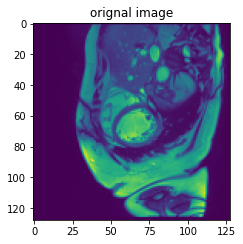

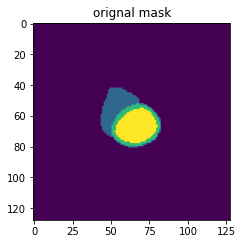

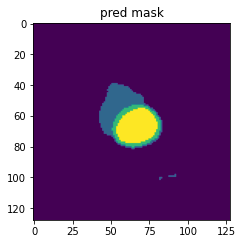

In [14]:
final_image_transpose = torch.squeeze(final_image).cpu().detach().numpy()
                                
final_mask_transpose = torch.squeeze(final_mask).cpu().detach().numpy()

pred_image_transpose = torch.squeeze(y_pred_idx).cpu().detach().numpy()


                                
                                
plt.figure(figsize = (12,4))
plt.subplot(1,3,1)
plt.imshow(final_image_transpose)
plt.title('orignal image')

plt.figure(figsize = (12,4))
plt.subplot(1,3,2)
plt.imshow(final_mask_transpose)
plt.title('orignal mask')

plt.figure(figsize = (12,4))
plt.subplot(1,3,3)
plt.imshow(pred_image_transpose)
plt.title('pred mask')

In [ ]:
total_mean

In [ ]:
total_std

In [ ]:
import pytorch_model_summary as pms

In [ ]:
model = Unet(3,1)

In [ ]:
print(pms.summary(model, torch.zeros((32, 3, 256, 256)), show_input=True, show_hierarchical=True))